In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu


from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from calibrate import calibrate

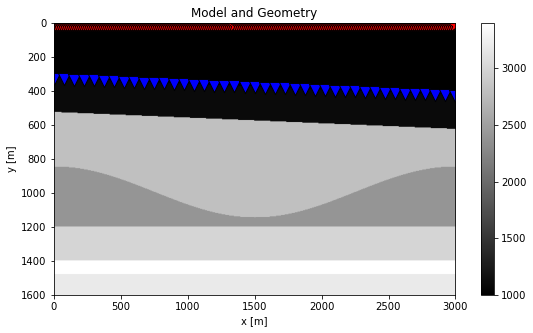

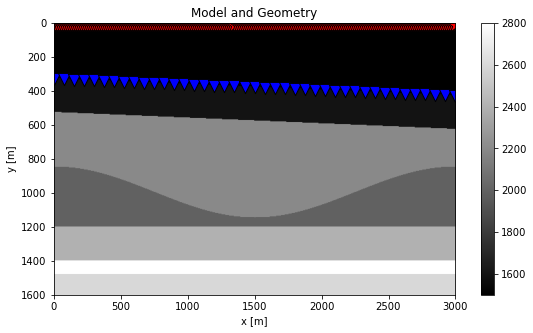

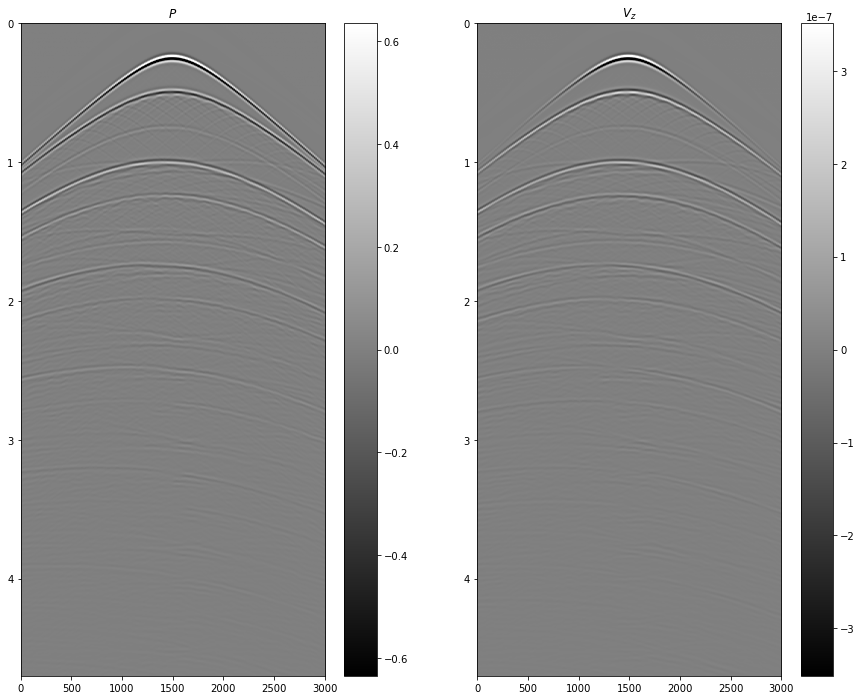

In [2]:
datapath = 'Data' # '' or '/home/ravasim/Documents/Data/fdva_dipping_old/'

inputfile = os.path.join(datapath, 'input_dipping_recsolid.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1600.0 # velocity at separation level
rho_sep = 1100.0 # density at separation level

#method = 'sum'
#method = 'rec_ana'
method = 'src_ana'
#method = 'src_inv'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
r = r[:, 201:]
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 941, 0.005
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

# Data
p = inputdata['p']
vz = inputdata['vz']
vx = inputdata['vz']


p = np.apply_along_axis(convolve, 1, p, wav, mode='full')
p = p[:, wav_c:][:, :nt]
vz = np.apply_along_axis(convolve, 1, vz, wav, mode='full')
vz = vz[:, wav_c:][:, :nt]
vx = np.apply_along_axis(convolve, 1, vx, wav, mode='full')
vx = vx[:, wav_c:][:, :nt]

# Normalize
vz /= p.max()
vx /= p.max()
p /= p.max()

clip=0.5

plt.figure(figsize=(9,5))
im = plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

fig, axs = plt.subplots(1, 2, figsize=(15,12))
im=axs[0].imshow(p[ns//2], cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$P$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(vz[ns//2], cmap='gray', vmin=-clip*np.abs(vz).max(), vmax=clip*np.abs(vz).max(),
                 extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$V_z$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1]);

In [3]:
method='src_ana'
data = np.load('updown_dipping_belowseabed_%s.npz'% method)
pup = data['pup'] 
pdown = data['pdown'] 

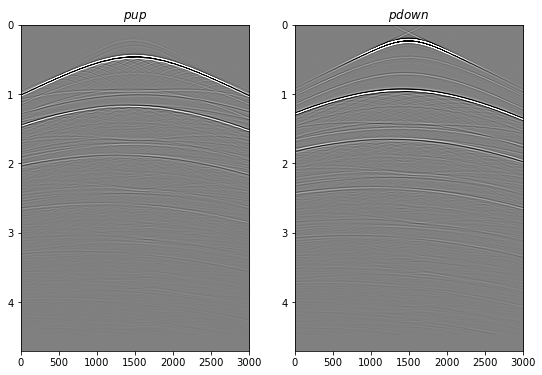

In [4]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50 # 400
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0))).astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0))).astype('float32')
ntpad = pup.shape[1]
tpad = np.arange(ntpad) * dt

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight');

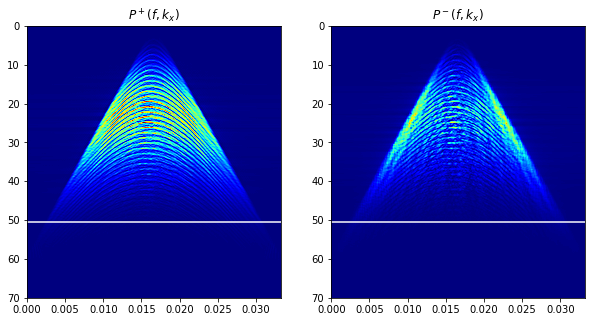

In [5]:
# check max frequency to use
nfmax=250#550
nfft = ntpad#2**11

FFTop = FFT2D(dims=[nr, ntpad], nffts=[nfft, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[ns//2].T.flatten()).reshape(nfft, nfft)


fig, axs = plt.subplots(1, 2, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(70, 0);
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight');
axs[1].set_ylim(70, 0);           

In [6]:
inputfile = os.path.join(datapath, 'input_dipping_noseabed_single_recsolid.npz')
inputdata = np.load(inputfile)

# data
Rtrue = inputdata['vz_noseabed']

In [7]:
pup = np.swapaxes(pup,2,1)
pdown = np.swapaxes(pdown,2,1)

pdown2 = np.concatenate((np.zeros((ns, nr, ntpad-1)), pdown), axis=-1)#.astype(np.float32)
pdown2.shape

(201, 201, 1981)

In [8]:
real_m = Rtrue.T
print(real_m.shape)

real_m = np.pad(real_m, ((0, 0), (0, npad))).astype('float32')

m = np.concatenate((np.zeros((nr, ntpad-1)), real_m), axis=-1).T
print(m.shape)

(201, 941)
(1981, 201)


In [9]:
pdown_fft = np.fft.rfft(pdown2, 2*ntpad-1, axis=-1)
pdown_fft = pdown_fft[...,:nfmax]
pdown_fft = pdown_fft.transpose(2,0,1)

MDCop=MDC(pdown_fft, nt=2*ntpad-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=0, verb=True)
print(MDCop.shape)

d = MDCop*m.flatten()
d = d.reshape(2*ntpad-1, ns)

Dot test passed, v^T(Opu)=-35226.952313 - u^T(Op^Tv)=-35226.952313
(398181, 398181)


In [10]:


madj = MDCop.H * d.ravel()
madj = madj.reshape(2*ntpad-1, nr)

In [11]:
d =  torch.from_numpy(d) #astype(np.float32))
m  =  torch.from_numpy(m) #astype(np.float32))
pdown2 = torch.from_numpy(pdown2)#.astype(np.float32))


In [12]:
lossdict_mini = {}
avgdict_mini = {}

In [13]:
def advoptMDD(model, optimizer, lr):
  if optimizer == 'SGD':

      optimizer = torch.optim.SGD([model], lr = lr)
   
  elif optimizer == 'Adadelta':
   
      optimizer = torch.optim.Adadelta([model], lr =lr)
    
  elif optimizer == 'Adam':
   
      optimizer= torch.optim.Adam([model], lr=lr)
   

  elif optimizer == 'RMSprop':
  
      optimizer= torch.optim.RMSprop([model], lr =lr, weight_decay=1e-3, eps = 1e-04)
   

  elif optimizer == 'Adagrad':
  
      optimizer= torch.optim.Adagrad([model], lr = lr)

  elif optimizer == 'Adamax':

      optimizer = torch.optim.Adamax([model], lr=lr)

      
    

  return optimizer


In [14]:
nv=1
class GwavSGD_mini(nn.Module):
  def __init__(self,ntpad,nfmax,nv,dt,dr,ns):
    self.ntpad = ntpad
    self.nfmax = nfmax
    self.nv = nv
    self.dt = dt
    self.dr =dr
    self.ns = ns
    super().__init__()
    

  def forward(self,model, batch):
    batch_size = batch.shape[0]
    
    pdown_fft = np.fft.rfft(batch, 2*self.ntpad-1, axis=-1)
    pdown_fft = pdown_fft[...,:self.nfmax]
    pdown_fft = pdown_fft.transpose(2,0,1)
    
    MDCop=MDC(pdown_fft, nt=2*self.ntpad-1, nv=self.nv, dt=self.dt, dr=self.dr, 
          twosided=True, transpose=False)
    
    
    
    MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
    
    data12 = MDCop.apply(model.flatten())
    data12 = data12.view(2*self.ntpad-1, batch_size)

    return data12


In [15]:


def advancedSolversMini(GwavSGD,model,d,pdown2,optimizer, lr, n_epochs, batch_size):

  d2 = torch.transpose(d, 1,0)
  no_of_batches=round(pdown2.shape[0]/batch_size)

 
  t_train = TensorDataset(pdown2, d2)
  trainloader = DataLoader(dataset = t_train, batch_size = batch_size, shuffle = True, drop_last = False)
  for x, y in trainloader:
    print(x.shape, y.shape)
  
  criterion = nn.MSELoss()
  optimizer = advoptMDD(model, optimizer, lr)

  nv=1
  GwavTorch = GwavSGD_mini(ntpad,nfmax,nv,dt,dr,ns)
  lossHist=[]
  lossavg=[]
  for epoch in range(n_epochs):
    losses=[]
    
    for batch,dbatch in trainloader: 
      
       data12= GwavTorch(model, batch)
       dbatch1 = torch.transpose(dbatch,1,0)
       loss = criterion(dbatch1, data12)
       
       loss.backward()
       optimizer.step()
       optimizer.zero_grad()

       lossHist.append(loss.item())
       losses.append(loss.item())
      
      
    avg_loss = sum(losses) / len(losses)
    lossavg.append(avg_loss)
       
       
    
    if (epoch+1) %10 ==0:
     print(f'epoch: {epoch+1}, loss : {loss.item():.4f}, loss avg : {avg_loss:.4f}')
    

    lossdict_mini[optimizer] = lossHist
    avgdict_mini[optimizer] = lossavg

  return lossHist, lossavg, data12



In [16]:
model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model.astype(np.float64))
model.requires_grad= True

model.shape

torch.Size([1981, 201])

In [17]:
n_epochs = 100
batch_size = 31

lossHist, lossavg, data12 = advancedSolversMini(GwavSGD_mini,model,d,pdown2,'Adadelta', lr =1, n_epochs =n_epochs, batch_size = batch_size)

torch.Size([31, 201, 1981]) torch.Size([31, 1981])
torch.Size([31, 201, 1981]) torch.Size([31, 1981])
torch.Size([31, 201, 1981]) torch.Size([31, 1981])
torch.Size([31, 201, 1981]) torch.Size([31, 1981])
torch.Size([31, 201, 1981]) torch.Size([31, 1981])
torch.Size([31, 201, 1981]) torch.Size([31, 1981])
torch.Size([15, 201, 1981]) torch.Size([15, 1981])
epoch: 10, loss : 0.0004, loss avg : 0.0004
epoch: 20, loss : 0.0001, loss avg : 0.0001
epoch: 30, loss : 0.0001, loss avg : 0.0001
epoch: 40, loss : 0.0001, loss avg : 0.0001
epoch: 50, loss : 0.0000, loss avg : 0.0000
epoch: 60, loss : 0.0000, loss avg : 0.0000
epoch: 70, loss : 0.0000, loss avg : 0.0000
epoch: 80, loss : 0.0000, loss avg : 0.0000
epoch: 90, loss : 0.0000, loss avg : 0.0000
epoch: 100, loss : 0.0000, loss avg : 0.0000


(-2.475, 2.475)

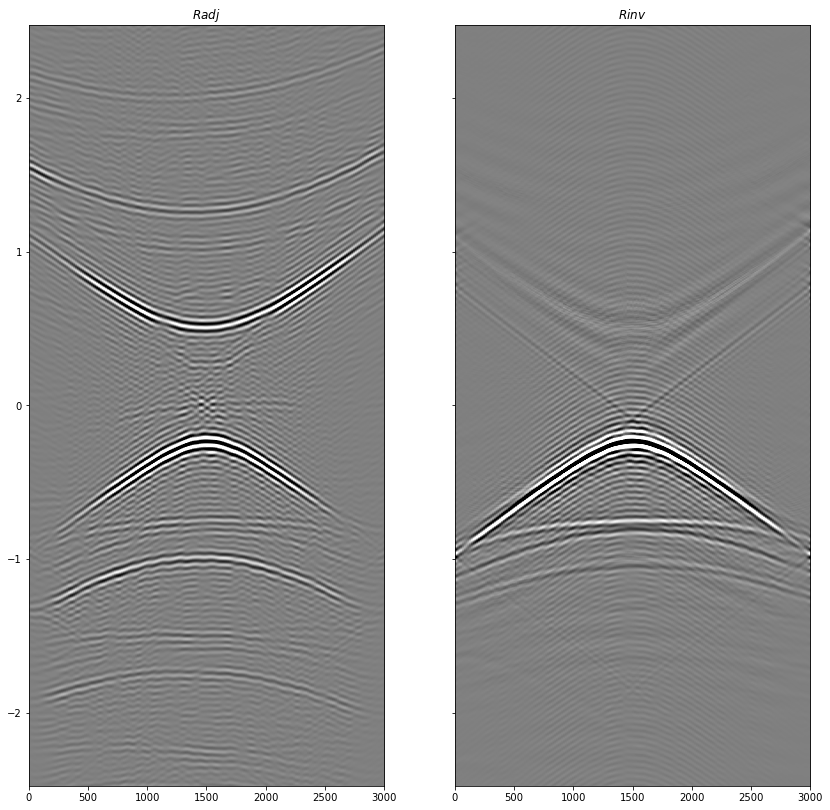

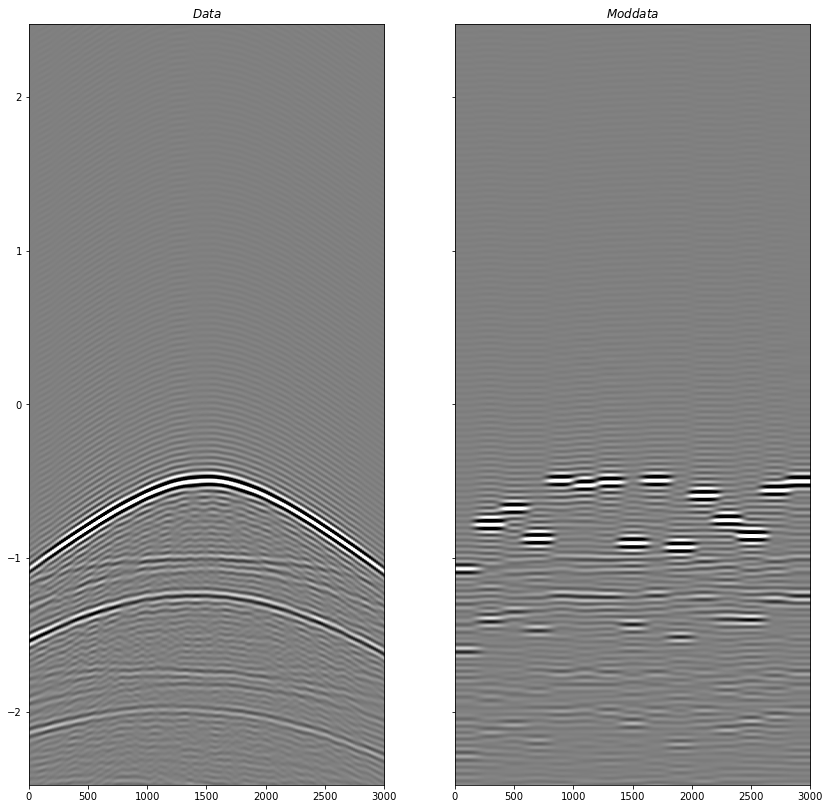

In [18]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,14))
axs[0].imshow(madj, cmap='gray', 
              vmin=-0.3*np.abs(madj).max(), vmax=0.3*np.abs(madj).max(),
              extent = (r[0, 0], r[0,-1], -tpad[-1], tpad[-1]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')

axs[1].imshow(model.detach().numpy(), cmap='gray', 
              vmin=-0.2*np.abs(model.detach().numpy()).max(), vmax=0.2*np.abs(model.detach().numpy()).max(),
              extent = (r[0, 0], r[0,-1], -tpad[-1], tpad[-1]))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight');
axs[1].set_ylim(-tpad[ntpad//2], tpad[ntpad//2])


fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,14))
axs[0].imshow(d, cmap='gray', 
              vmin=-0.3*np.abs(d).max(), vmax=0.3*np.abs(d).max(),
              extent = (r[0, 0], r[0,-1], -tpad[-1], tpad[-1]))
axs[0].set_title(r'$Data$')
axs[0].axis('tight')
axs[1].imshow(data12.detach().numpy(), cmap='gray', 
              vmin=-0.3*np.abs(d).max(), vmax=0.3*np.abs(d).max(),
              # vmin=-0.2*np.abs(data1.detach().numpy()).max(), vmax=0.2*np.abs(data1.detach().numpy()).max(),
              extent = (r[0, 0], r[0,-1], -tpad[-1], tpad[-1]))
axs[1].set_title(r'$Mod data$')
axs[1].axis('tight');
axs[1].set_ylim(-tpad[ntpad//2], tpad[ntpad//2])



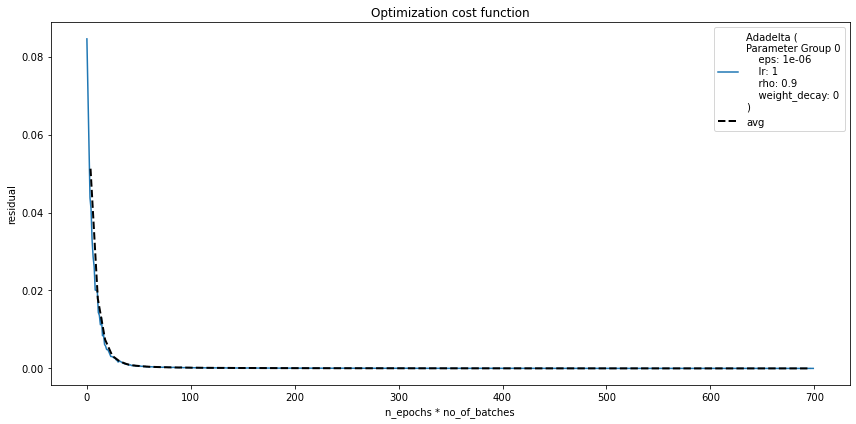

In [20]:
no_of_batches=np.ceil(pdown2.shape[0]/batch_size)

for loss, avg in zip(lossdict_mini.keys(), avgdict_mini.keys()):
    
  fig = plt.figure(figsize= (12,6))
  plt.plot(lossdict_mini[loss], label = loss)
  plt.plot(np.arange(0, no_of_batches*n_epochs, no_of_batches)+no_of_batches/2,avgdict_mini[avg], 'k--',label = "avg", linewidth = 2)
  plt.xlabel('n_epochs * no_of_batches')
  plt.ylabel('residual')
  plt.title("Optimization cost function")
  plt.legend()
  plt.tight_layout()